# OpenEO Connection to Google Earth Engine

In [1]:
import openeo
from openeo.internal.graph_building import PGNode
import json
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
# Define constants

# Connection
GEE_DRIVER_URL = "https://earthengine.openeo.org/v1.0"
OUTPUT_FILE = "/tmp/openeo_gee_output.png"
OUTFORMAT = "png"

# Auth
USER = "group1"
PASSWORD = "test123"

# Data
PRODUCT_ID = "COPERNICUS/S2"

DATE_START = "2017-01-01T00:00:00Z"
DATE_END = "2017-01-31T23:59:59Z"

IMAGE_WEST = 16.138916
IMAGE_EAST = 16.524124
IMAGE_NORTH = 48.320647
IMAGE_SOUTH = 48.138600
IMAGE_SRS = "EPSG:4326"

# Processes
NDVI_RED = "B4"
NDVI_NIR = "B8"

STRECH_COLORS_MIN = -1
STRECH_COLORS_MAX = 1

In [3]:
# Connect with GEE backend and authenticate with basic authentication
con = openeo.connect(GEE_DRIVER_URL)
con.authenticate_basic(USER, PASSWORD)
con

In [4]:
# Get available processes from the back end.
processes = con.list_processes()
processes

[{'id': 'absolute',
  'summary': 'Absolute value',
  'description': 'Computes the absolute value of a real number `x`, which is the "unsigned" portion of x and often denoted as *|x|*.\n\nThe no-data value `null` is passed through and therefore gets propagated.',
  'categories': ['math'],
  'parameters': [{'name': 'x',
    'description': 'A number.',
    'schema': {'type': ['number', 'null']},
    'optional': True}],
  'returns': {'description': 'The computed absolute value.',
   'schema': {'type': ['number', 'null'], 'minimum': 0}},
  'examples': [{'arguments': {'x': 0}, 'returns': 0},
   {'arguments': {'x': 3.5}, 'returns': 3.5},
   {'arguments': {'x': -0.4}, 'returns': 0.4},
   {'arguments': {'x': -3.5}, 'returns': 3.5}],
  'links': [{'rel': 'about',
    'href': 'http://mathworld.wolfram.com/AbsoluteValue.html',
    'title': 'Absolute value explained by Wolfram MathWorld'}],
  'process_graph': {'lt': {'process_id': 'lt',
    'arguments': {'x': {'from_parameter': 'x'}, 'y': 0}},
   'm

In [5]:
# Retrieve the list of available collections
collections = con.list_collections()

list(collections)[:2]

[{'stac_version': '0.9.0',
  'stac_extensions': [],
  'id': 'AAFC/ACI',
  'title': 'Canada AAFC Annual Crop Inventory',
  'description': 'Starting in 2009, the Earth Observation Team of the Science and Technology\nBranch (STB) at Agriculture and Agri-Food Canada (AAFC) began the process\nof generating annual crop type digital maps. Focusing on the Prairie\nProvinces in 2009 and 2010, a Decision Tree (DT) based methodology was\napplied using optical (Landsat-5, AWiFS, DMC) and radar (Radarsat-2) based\nsatellite images. Beginning with the 2011 growing season, this activity has\nbeen extended to other provinces in support of a national crop inventory.\nTo date this approach can consistently deliver a crop inventory that meets\nthe overall target accuracy of at least 85% at a final spatial resolution of\n30m (56m in 2009 and 2010).\n',
  'license': 'proprietary',
  'providers': [{'name': 'Agriculture and Agri-Food Canada',
    'roles': ['producer', 'licensor'],
    'url': 'https://open.ca

In [6]:
# Get detailed information about a collection
process = con.describe_collection('COPERNICUS/S2')
process

{'stac_version': '0.9.0',
 'id': 'COPERNICUS/S2',
 'title': 'Sentinel-2 MSI: MultiSpectral Instrument, Level-1C',
 'description': 'Sentinel-2 is a wide-swath, high-resolution, multi-spectral\nimaging mission supporting Copernicus Land Monitoring studies,\nincluding the monitoring of vegetation, soil and water cover,\nas well as observation of inland waterways and coastal areas.\n\nThe Sentinel-2 data contain 13 UINT16 spectral bands representing\nTOA reflectance scaled by 10000. See the [Sentinel-2 User Handbook](https://sentinel.esa.int/documents/247904/685211/Sentinel-2_User_Handbook)\nfor details. In addition, three QA bands are present where one\n(QA60) is a bitmask band with cloud mask information. For more\ndetails, [see the full explanation of how cloud masks are computed.](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-1c/cloud-masks)\n\nEach Sentinel-2 product (zip archive) may contain multiple\ngranules. Each granule becomes a separate Earth Engin

In [8]:
# Select collection product to get a datacube object
datacube = con.load_collection("COPERNICUS/S2")

In [9]:
# Specifying the date range, the bounding box and bands
datacube = datacube.filter_bbox(west=IMAGE_WEST, east=IMAGE_EAST, north=IMAGE_NORTH,
                                             south=IMAGE_SOUTH, crs=IMAGE_SRS)
datacube = datacube.filter_temporal(DATE_START, DATE_END)

datacube = datacube.filter_bands([NDVI_RED, NDVI_NIR])

datacube.graph

{'loadcollection1': {'process_id': 'load_collection',
  'arguments': {'id': 'COPERNICUS/S2',
   'spatial_extent': None,
   'temporal_extent': None}},
 'filterbbox1': {'process_id': 'filter_bbox',
  'arguments': {'data': {'from_node': 'loadcollection1'},
   'extent': {'west': 16.138916,
    'east': 16.524124,
    'north': 48.320647,
    'south': 48.1386,
    'crs': 'EPSG:4326'}}},
 'filtertemporal1': {'process_id': 'filter_temporal',
  'arguments': {'data': {'from_node': 'filterbbox1'},
   'extent': ['2017-01-01T00:00:00Z', '2017-01-31T23:59:59Z']}},
 'filterbands1': {'process_id': 'filter_bands',
  'arguments': {'bands': ['B4', 'B8'],
   'data': {'from_node': 'filtertemporal1'}},
  'result': True}}

In [10]:
# Applying some operations on the data

# Defining NDVI reducer
red = PGNode("array_element", arguments={"data": {"from_parameter": "data"}, "label": "B4"})
nir = PGNode("array_element", arguments={"data": {"from_parameter": "data"}, "label": "B8"})
ndvi = PGNode("normalized_difference", arguments={"x": {"from_node": nir}, "y": {"from_node": red}})

datacube = datacube.reduce_dimension(dimension="bands", reducer=ndvi)

# take minimum time to reduce by time
datacube = datacube.min_time(dimension='t')

# Linear scale necessary for GEE png export
lin_scale = PGNode("linear_scale_range", arguments={"x": {"from_parameter": "x"}, "inputMin": -1, "inputMax": 1, "outputMax": 255})
datacube = datacube.apply(lin_scale)

# Save result as PNG
datacube = datacube.save_result(format="PNG")

datacube.graph

'{\n  "loadcollection1": {\n    "process_id": "load_collection",\n    "arguments": {\n      "id": "COPERNICUS/S2",\n      "spatial_extent": null,\n      "temporal_extent": null\n    }\n  },\n  "filterbbox1": {\n    "process_id": "filter_bbox",\n    "arguments": {\n      "data": {\n        "from_node": "loadcollection1"\n      },\n      "extent": {\n        "west": 16.138916,\n        "east": 16.524124,\n        "north": 48.320647,\n        "south": 48.1386,\n        "crs": "EPSG:4326"\n      }\n    }\n  },\n  "filtertemporal1": {\n    "process_id": "filter_temporal",\n    "arguments": {\n      "data": {\n        "from_node": "filterbbox1"\n      },\n      "extent": [\n        "2017-01-01T00:00:00Z",\n        "2017-01-31T23:59:59Z"\n      ]\n    }\n  },\n  "filterbands1": {\n    "process_id": "filter_bands",\n    "arguments": {\n      "bands": [\n        "B4",\n        "B8"\n      ],\n      "data": {\n        "from_node": "filtertemporal1"\n      }\n    }\n  },\n  "reducedimension1": {\

In [11]:
# Sending the job to the backend
job = datacube.send_job()
job.start_job()
job

<RESTJob job_id='VucGeUJIv1IcIahy'>

In [14]:
# Describe Job
job.describe_job()

{'id': 'VucGeUJIv1IcIahy',
 'title': None,
 'description': None,
 'status': 'finished',
 'created': '2020-04-02T09:15:58Z',
 'updated': '2020-04-02T09:15:58Z',
 'plan': 'free',
 'costs': 0,
 'budget': None,
 'process': {'process_graph': {'loadcollection1': {'process_id': 'load_collection',
    'arguments': {'id': 'COPERNICUS/S2',
     'spatial_extent': None,
     'temporal_extent': None}},
   'filterbbox1': {'process_id': 'filter_bbox',
    'arguments': {'data': {'from_node': 'loadcollection1'},
     'extent': {'west': 16.138916,
      'east': 16.524124,
      'north': 48.320647,
      'south': 48.1386,
      'crs': 'EPSG:4326'}}},
   'filtertemporal1': {'process_id': 'filter_temporal',
    'arguments': {'data': {'from_node': 'filterbbox1'},
     'extent': ['2017-01-01T00:00:00Z', '2017-01-31T23:59:59Z']}},
   'filterbands1': {'process_id': 'filter_bands',
    'arguments': {'bands': ['B4', 'B8'],
     'data': {'from_node': 'filtertemporal1'}}},
   'reducedimension1': {'process_id': 're

In [16]:
# Download job result
job.download_result(OUTPUT_FILE)

job

<RESTJob job_id='VucGeUJIv1IcIahy'>

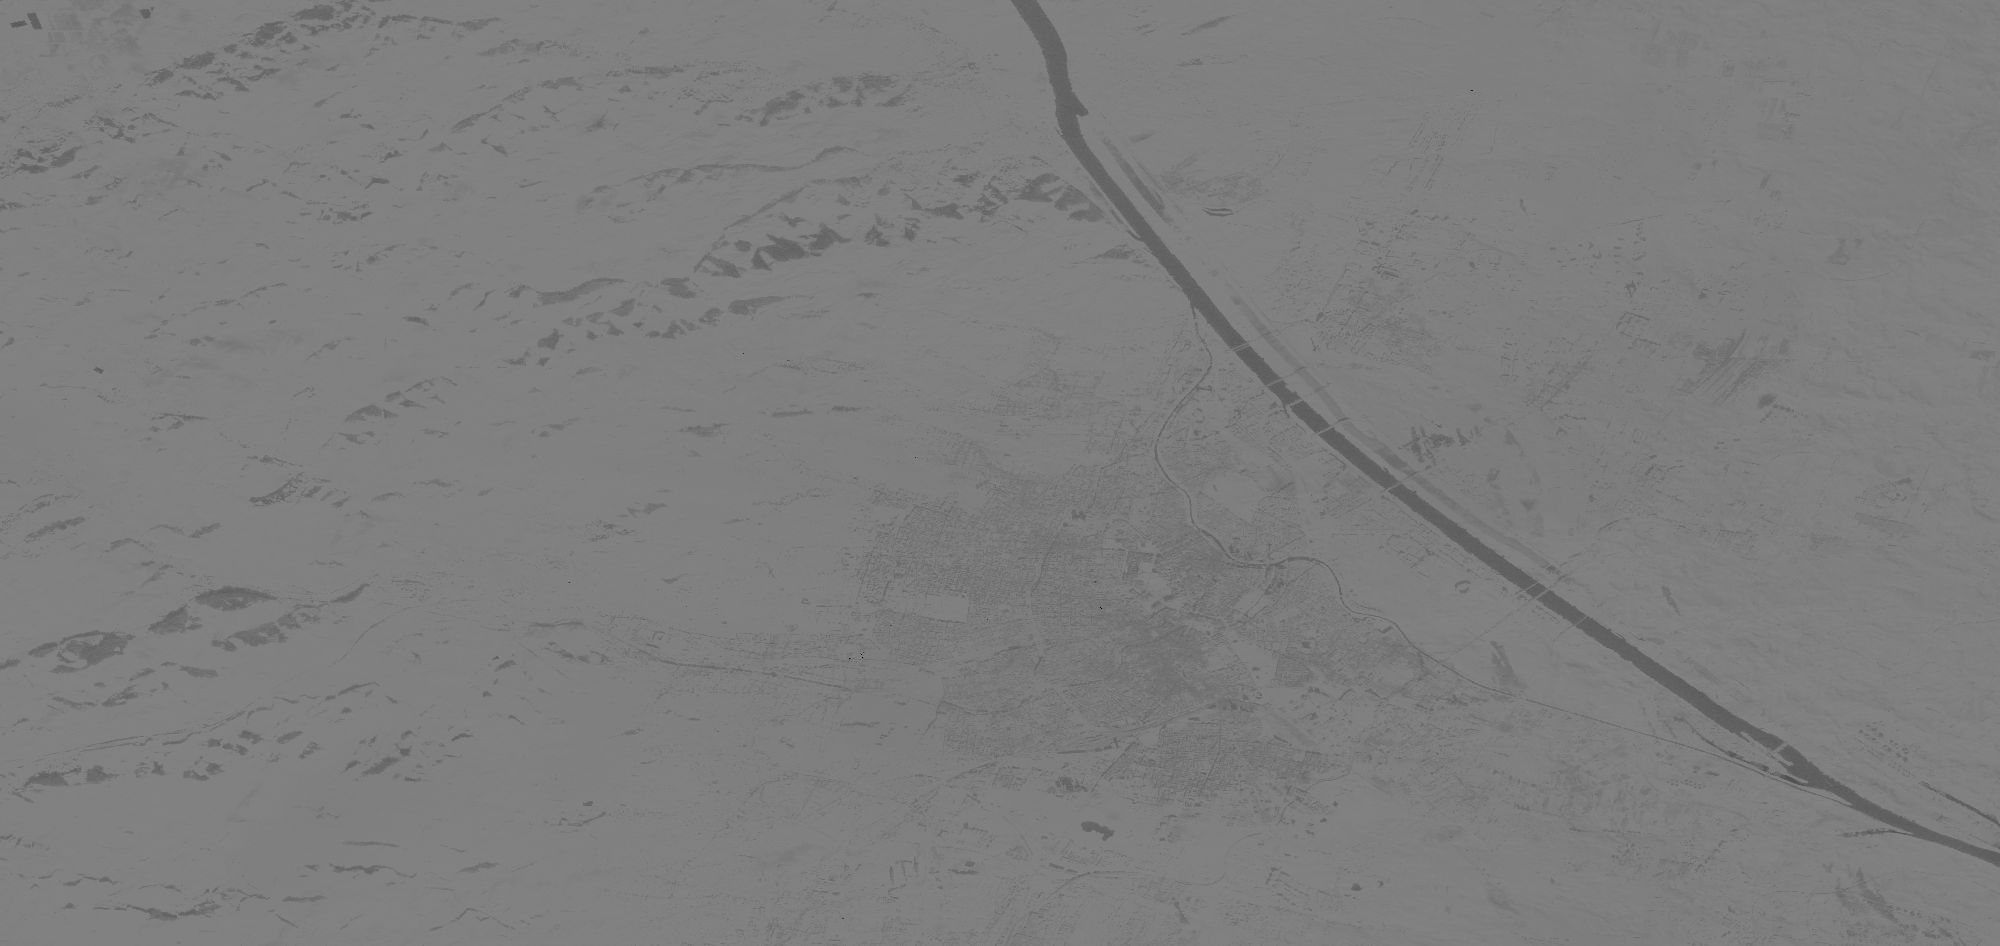

In [17]:
# Showing the result
from IPython.display import Image
result = Image(filename=OUTPUT_FILE)

result